<a id="top"></a>
# Visualization of Roman APT products
***
## Learning Goals

By the end of this tutorial you will:

- Open and read APT pointings or simulator input files.
- Build (interactive) maps using Roman APT files indicating number of exposures in a given patch of the sky, exposure time, etc.


## Introduction

This notebook tries to illustrate several examples of how to visualize APT products in Python. Note that the APT GUI already has Aladdin visualization, and the tool presented in this notebook is complementary.

The utility functions defined in `footprint_utils.py` use one of the following APT special outputs:

* A pointings file -- this file includes the pointing information from all pointing positions in a given APT program.
* A simulator input file -- this file, originally intended to work as input for Roman's image simulation software: `romanIsim`, contains information about all exposures and the position of the `WFI_CEN` aperture, together with duration, and filter element.


On this notebook we will demonstrate how to visualize both. Additionally, we will demonstrate how to build these visualizations serially or in parallel. Note: In order to take full advantage of parallelization, the parameters (number of threads / number of processes) need to be optimized according to the machine and inputs used.


The workflow for this notebook consists of:
* [Creating and loading APT outputs](#APT-outputs)
* [Working with `pointing` files](#Pointing-file)
    * [Reading pointings files](#Pointings-file-reading)
    * [Visualizing pointings files](#Pointings-file-visualization)
* [Working with simulator input files](#Simulator-input-file)
    * [Reading simulator input files](#Sim-file-reading)
    * [Visualizing pointings files](#Sim-file-visualization)


## Imports

- *numpy* to handle array functions
- *matplotlib* for plotting data
- *astropy.table* for creating tidy tables of the data
- *pandas* for creating tidy tables of the data
- *healsparse* to generate lightweight partial-sky high-resolution HEALPix maps
- *skyproj* to generate sky plots using different projections
- *dask* (Optional) to perform parallel processing

In [1]:
import numpy as np
from footprint_utils import *
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import astropy.table

Two packages that will be used throughout the notebook are `healsparse` and `skyproj`. If you want to install these, please uncomment the cell below:

In [2]:
# !pip install healsparse
# !pip install skyproj

In [3]:
import healsparse as hsp
import skyproj

By default this notebook will allow you to produce interactive plots, however, some of the plots presented here could lead to reduced performance in certain systems. In order to generate static plots, please the `interactive` variable below to `False`

In [4]:
interactive = True
if interactive:
    %matplotlib widget
else:
    %matplotlib inline

***

# Creating and loading APT outputs

The [Astronomer's Proposal Tool (APT)](https://www.stsci.edu/scientific-community/software/astronomers-proposal-tool-apt) allows the user to design a General Astrophysics Survey with the Wide Field Instrument, and it was used to design the Roman's Core Community Surveys. Given an APT program, the user can export a variety of products using the command line. In this notebook we will focus on two products: the `pointings` file, and the `simulator input` file.

In order to export these files the user can execute the following command in a terminal:

`PATH_TO_APT_PARENT_DIRECTORY/bin/apt -export pointing,sim PATH_TO_APT_FILE/my_apt_file.apt -nogui -output PATH_TO_OUTPUT_DIRECTORY`

This command will generate a pointings file: `my_apt_file.pointing` and a simulator input file: `my_apt_file.sim.ecsv`. In the next sections we will describe what these files contain and how to read them.

# Working with `pointing` files

## Reading a pointings file

A pointings file contains information about all survey steps, mosaic patterns and region targets defined in a program. For more information about these concepts we encourage the user follow the Roman documentation ([RDox](https://roman-docs.stsci.edu)). In `footprint_utilities` we define a parsing function to interpret these pointing files. The `read_pointings_file` function reads a pointings file as produced by APT and returns two `pandas.DataFrame` objects, that below we will name `obs_all`, and `reg_all`. The first DataFrame, `obs_all` in our case, encodes the observing strategy of a single mosaic segment (see RDox for more information: https://roman-docs.stsci.edu) on each survey step. The second one, `reg_all` in our case, contains the reference pointing positions (`ra_ref, dec_ref, PA`) of the `WFI_CEN` aperture for each segment in all of the region targets defined in the APT program that was used to create the `.pointing` file.

Below, we use an example `pointing` file resulting from an early version of Roman's High-Latitude Wide-Area Survey. However, the parser function should work for any `pointing` file.

In [5]:
obs_all, reg_all = read_pointings_file('./aux_data/roman_hlwas.pointing')

In [6]:
obs_all

,Step,Observation,Tile,Exposure,V2,V3,Dither_X,Dither_Y,Subpixel_X,Subpixel_Y,dDist,Tile_X,Tile_Y,Total_X,Total_Y
0,1,1,1,1,-692.977356,5429.557617,0.0,0.000000,0.0,0.0,0.000000,-4357.444336,5101.984863,-4357.444336,5101.984863
1,1,1,1,2,-1003.962402,5733.450195,-108.0,421.559998,0.0,0.0,0.120759,-4357.444336,5101.984863,-4465.444336,5523.544922
2,1,1,1,3,-1496.296997,6214.488770,-279.0,1089.000000,0.0,0.0,0.191160,-4357.444336,5101.984863,-4636.444336,6190.984863
3,1,1,2,1,569.185120,4701.578613,0.0,0.000000,0.0,0.0,0.711030,-4357.444336,3644.274902,-4357.444336,3644.274902
4,1,1,2,2,258.154755,5005.608398,-108.0,421.559998,0.0,0.0,0.120800,-4357.444336,3644.274902,-4465.444336,4065.834961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14351,120,1,15,2,-1609.999146,-4027.912354,-108.0,421.559998,0.0,0.0,0.120854,4401.908203,744.039429,4293.908203,1165.599487
14352,120,1,15,3,-2102.385010,-3546.114014,-279.0,1089.000000,0.0,0.0,0.191343,4401.908203,744.039429,4122.908203,1833.039429
14353,120,1,16,1,-2587.359863,-3588.022705,0.0,0.000000,0.0,0.0,0.135197,4401.908203,2232.118408,4401.908203,2232.118408
14354,120,1,16,2,-2898.299072,-3283.716553,-108.0,421.559998,0.0,0.0,0.120844,4401.908203,2232.118408,4293.908203,2653.678467


The `obs_all` DataFrame describes the mosaic patterns for a single segment in a Survey Step (given by the `Step` column). The `Tile` column gives the information about the tile number in the mosaic, and `Exposure` is the dither number of each tile. `V2`, and `V3` are referred to the original reference position in arcsec. This DataFrame also contains Ideal offset from the dither (`Dither_X, Dither_Y`), Ideal subpixel dither offset (`Subpixel_X, Subpixel_Y`), the dither distance with respect to the reference point `dDist`, ideal offset from the mosaic (or tile size if calculated from the dimensions of the aperture -- `Tile_X, Tyle_Y`, and Total ideal offset treated as being in the pointing aperture ideal frame (`Total_X, Total_Y`). For more information about the different appertures and conventions we recommend reading the [RDox](https://roman-docs.stsci.edu).

In [7]:
reg_all

,Region,Index,ra_ref,dec_ref,PA,RA,Dec,V2,V3
0,HLWAS-wide-field1\n,1,179.077149,-8.247869,60.0,156.681000,-4.186000,-52887.281250,-62643.640625
1,HLWAS-wide-field1\n,2,179.077149,-8.247869,60.0,156.718994,-2.532000,-58204.515625,-59547.628906
2,HLWAS-wide-field1\n,3,179.077149,-8.247869,60.0,156.738007,-0.879000,-63509.707031,-56472.160156
3,HLWAS-wide-field1\n,4,179.077149,-8.247869,60.0,156.738998,0.775000,-68806.117188,-53418.843750
4,HLWAS-wide-field1\n,5,179.077149,-8.247869,60.0,156.720993,2.428000,-74096.867188,-50389.281250
...,...,...,...,...,...,...,...,...,...
1108,HLWAS-medium-field2\n,440,37.968750,-25.842800,60.0,78.444000,-24.497999,86269.835938,102284.968750
1109,HLWAS-medium-field2\n,441,37.968750,-25.842800,60.0,77.935997,-22.844999,80682.835938,106071.796875
1110,HLWAS-medium-field2\n,442,37.968750,-25.842800,60.0,77.472000,-21.191999,75084.867188,109855.851562
1111,HLWAS-medium-field2\n,443,37.968750,-25.842800,60.0,77.051003,-19.538000,69469.734375,113637.867188


The `reg_all` DataFrame includes the `Region` name, the RA, and Dec position of the reference point of the Region, which are expressed in the `ra_ref`, `dec_ref` columns (i.e., the center of the Region itself, do not confuse this with the reference point for each segment). The `RA` of the center of the segment (in degrees), the `Dec` of the center of the segment (in degrees) and the `V2` and `V3` angles in arcsec with respect to the reference point of the region.

## Visualizing a `pointing` files

In the `obs_all` and `reg_all` dataframes we have encoded all the pointing positions in the APT program used to generate the pointings file that we have read. Now we want to visualize these. 
A convenient way to represent and manipulate the information contained in these pointings file is to build `healsparse` maps (more info at: https://healsparse.readthedocs.io). These are sparse representations of `HEALPix` maps (i.e., the do not carry in memory regions of the sky that are not observed, which is convenient for high-resolution, small-area maps). The `skyproj` (more info at: https://skyproj.readthedocs.io) package has convenient function to visualize these maps.

Unfortunately, in order to visualize the observing strategy of a certain region, a certain pass, or the observations on a given filter, we need to connect the `obs_all` and `reg_all` dataframes with information that is not (currently) available on either of these objects (nor in the pointings file itself). So we need to go the the APT GUI, open the original program, and see which Survey Step corresponds to which target / filter combination. In this example we are going to focus on visualizing one (out of two) of the regions of the HLWAS Medium tier, and we are interested in visualizing the number of exposures in the F129 filter. In our particular case, going to the APT file we see that the first pass corresponds to Survey Step 95 (see screenshot below). The second pass corresponds to Survey Step 96.

<img src="./aux_data/screenshot.png" width="800" height="600"/>


In [8]:
# We select only observations that correspond to Step 95 (first pass)
obs_filter = (obs_all['Step'] == 95) 
reg_filter = reg_all['Region'] == 'HLWAS-medium-field1\n'
print('Number of exposures per segment:', np.count_nonzero(obs_filter))
print('Number of segments:', np.count_nonzero(reg_filter))

Number of exposures per segment: 48
Number of segments: 72


The idea now is to perform a `for` loop that, for every segment in that region (i.e., reg_all[reg_filter]), goes over all the exposures in said segment (i.e., the observations in `obs_all[obs_filter]`.

So, a given entry in `reg_all[reg_filter]` will contain the reference position for one segment, and we will use the `v2, v3` information in `obs_all[obs_filter]` to build the full mosaic in the segment.

We show an example below and execute this serially.

In [9]:
ra_ref0, dec_ref0, pa_ref0 = reg_all[reg_filter]['RA'].values[0], reg_all[reg_filter]['Dec'].values[0], reg_all[reg_filter]['PA'].values[0]
map_all = None
flip = -1  # In APT v.2025.4 the sign of V2, V3 are flipped with respect to the `pysiaf` convention
nside_cov = 64  # Nside for coverage map -- set it a low number if the region of the sky to be covered is large
nside_sparse = 8192  # Nside for the high-resolution map -- the larger the number the higher the resolution of the map, but the more memory is needed

for v2, v3 in zip(obs_all[obs_filter]['V2'].values, obs_all[obs_filter]['V3'].values):
    map_here = build_single_exp_map_ref(ra_ref0, dec_ref0, pa_ref0, 
                                        flip*v2, flip*v3,
                                        nside_cov, nside_sparse)
    if map_all is None:
        map_all = map_here
    else:
        map_all = hsp.sum_union([map_all, map_here])

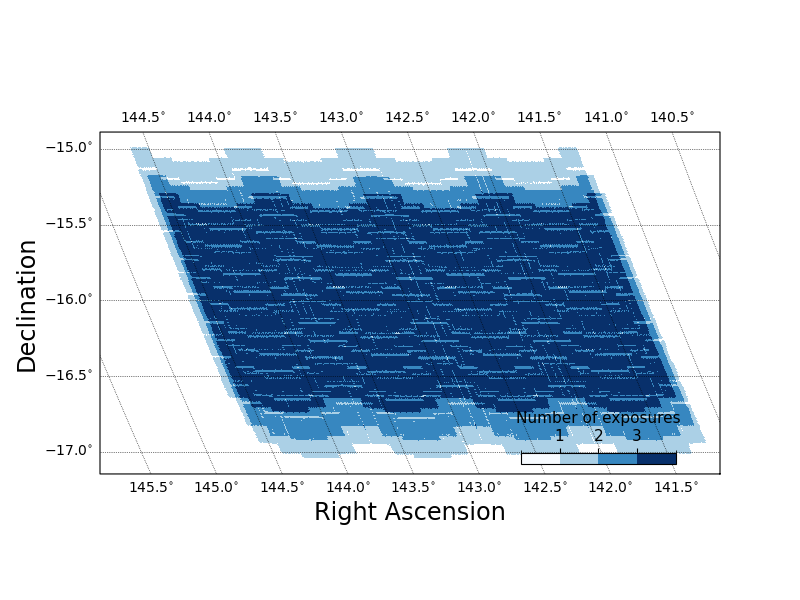

In [10]:
fig = plt.figure(1, figsize=(8, 6))
fig.clf()
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax)

# We define here a custom colorbar for illustration purposes
cmap = plt.cm.Blues  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0, 4, 5)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
# Note that the default is to zoom in to the range defined by the map
_ = sp.draw_hspmap(map_all, cmap=cmap, norm=norm)
# Set up the colorbar
cbar, _ = sp.draw_inset_colorbar(label='Number of exposures', height='3%', bbox_to_anchor=(-0.06, 0.01, 1, 1), loc=4, ticks=[1, 2, 3])
cbar.ax.set_xticklabels(['1', '2', '3'])
plt.show()

With large programs execute these loops serially becomes cumbersome, since each segment is independent, this is a simple-to-parallelize problem. We include an example of how to do so below.

In this case we will use `dask`, and the helper function `partial` in order to compress the arguments of
`build_single_exp_map_ref`.

In [11]:
from dask.distributed import Client
import dask.array as da
from functools import partial
client = Client()

2025-10-06 15:43:07,136 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:62508 (pid=46110) exceeded 95% memory budget. Restarting...
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

2025-10-06 15:43:11,313 - distributed.nanny - WARNING - Restarting worker
2025-10-06 16:06:15,332 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:62701 (pid=47000) exceeded 95% memory budget. Restarting...
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 

In [12]:
# First we create a list with all of the ra, dec, pa positions for the reference

ra_ref_all = reg_all[reg_filter]['RA'].values
dec_ref_all = reg_all[reg_filter]['Dec'].values
pa_ref_all = reg_all[reg_filter]['PA'].values

# Collect all v2, v3 from our observations

v2_all = obs_all[obs_filter]['V2'].values
v3_all = obs_all[obs_filter]['V3'].values

# Repeat them and construct an array with nsegments x nexp

ra_ref_all = ra_ref_all[:, None] * np.ones(v3_all.shape[0])
dec_ref_all = dec_ref_all[:, None] * np.ones(v3_all.shape[0])
pa_ref_all = pa_ref_all[:, None] * np.ones(v3_all.shape[0])

v2_all = v2_all[None, :] * np.ones(ra_ref_all.shape[0])[:, None]
v3_all = v3_all[None, :] * np.ones(ra_ref_all.shape[0])[:, None]

# Flatten to pass to our multiprocessing function

ra_ref_all = da.from_array(ra_ref_all.flatten())
dec_ref_all = da.from_array(dec_ref_all.flatten())
pa_ref_all = da.from_array(pa_ref_all.flatten())
v2_all = da.from_array(v2_all.flatten())
v3_all = da.from_array(v3_all.flatten())

map_here = client.map(partial(build_single_exp_map_ref, nside_sparse=nside_sparse, nside_cov=nside_cov), ra_ref_all,
                       dec_ref_all, pa_ref_all, v2_all, v3_all)

In [13]:
total = client.map(hsp.sum_union, [map_here])

In [14]:
map_new = total[0].result()

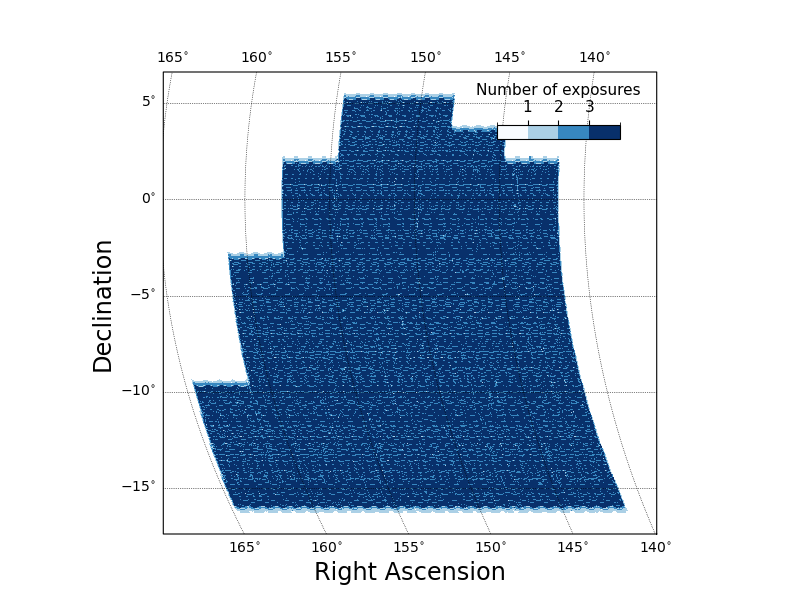

In [15]:
fig = plt.figure(2, figsize=(8, 6))
fig.clf()
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax)

# We define here a custom colorbar for illustration purposes
cmap = plt.cm.Blues  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0, 4, 5)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
# Note that the default is to zoom in to the range defined by the map
_ = sp.draw_hspmap(map_new, cmap=cmap, norm=norm)
# Set up the colorbar
cbar, _ = sp.draw_inset_colorbar(label='Number of exposures', height='3%', bbox_to_anchor=(-0.06, -0.1, 1, 1), loc=1, ticks=[1, 2, 3])
cbar.ax.set_xticklabels(['1', '2', '3'])
plt.show()

One more example, now with two passes:

In [16]:
obs_filter = (obs_all['Step'] == 95) | (obs_all['Step'] == 96)
reg_filter = reg_all['Region'] == 'HLWAS-medium-field1\n'
print('Number of exposures per segment:', np.count_nonzero(obs_filter))
print('Number of segments:', np.count_nonzero(reg_filter))

# First we create a list with all of the ra, dec, pa positions for the reference

ra_ref_all = reg_all[reg_filter]['RA'].values
dec_ref_all = reg_all[reg_filter]['Dec'].values
pa_ref_all = reg_all[reg_filter]['PA'].values

# Collect all v2, v3 from our observations

v2_all = obs_all[obs_filter]['V2'].values
v3_all = obs_all[obs_filter]['V3'].values

# Repeat them and construct an array with nsegments x nexp

ra_ref_all = ra_ref_all[:, None] * np.ones(v3_all.shape[0])
dec_ref_all = dec_ref_all[:, None] * np.ones(v3_all.shape[0])
pa_ref_all = pa_ref_all[:, None] * np.concatenate([np.ones(v3_all.shape[0]//2), np.ones(v3_all.shape[0]//2)*227/60])  # Trick to force the second pass to PA=227 -- feature from APT 2025.4 exporter

v2_all = v2_all[None, :] * np.ones(ra_ref_all.shape[0])[:, None]
v3_all = v3_all[None, :] * np.ones(ra_ref_all.shape[0])[:, None]


# Flatten to pass to our multiprocessing function

ra_ref_all = da.from_array(ra_ref_all.flatten())
dec_ref_all = da.from_array(dec_ref_all.flatten())
pa_ref_all = da.from_array(pa_ref_all.flatten())
v2_all = da.from_array(v2_all.flatten())
v3_all = da.from_array(v3_all.flatten())

map_here = client.map(partial(build_single_exp_map_ref, nside_sparse=nside_sparse, nside_cov=nside_cov), ra_ref_all,
                       dec_ref_all, pa_ref_all, v2_all, v3_all)

Number of exposures per segment: 96
Number of segments: 72


In [17]:
total = client.map(hsp.sum_union, [map_here])

In [18]:
map_new = total[0].result()

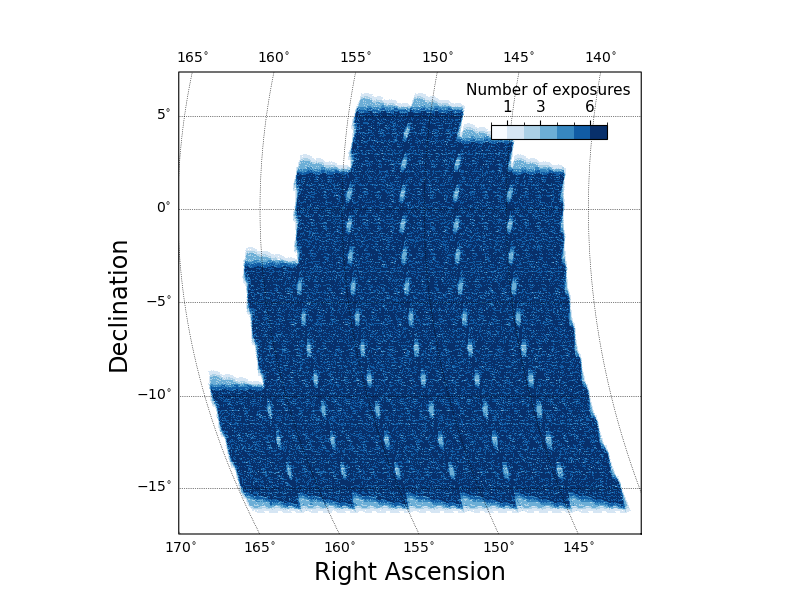

In [19]:
fig = plt.figure(3, figsize=(8, 6))
fig.clf()
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax)

# We define here a custom colorbar for illustration purposes
cmap = plt.cm.Blues  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0, 7, 8)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
# Note that the default is to zoom in to the range defined by the map
_ = sp.draw_hspmap(map_new, cmap=cmap, norm=norm)
# Set up the colorbar
cbar, _ = sp.draw_inset_colorbar(label='Number of exposures', height='3%', bbox_to_anchor=(-0.06, -0.1, 1, 1), loc=1, ticks=[1, 3, 6])
cbar.ax.set_xticklabels(['1', '3', '6'])
plt.show()

The non uniformities are caused by the fact that the region tiling has been defined using the original PA angle (60 degrees). For future versions this will be updated.

# Working with simulator input files

## Reading a simulator input file `sim.ecsv`

The simulator input file `*.sim.ecsv` is an output from APT intended to be used as input in `romanisim` to generate simulated images. It contains information about the position `RA, Dec` of the `WFI_CEN` aperture for eaach exposure in the program, together with information about the filter element used, and the duration in seconds (Note: duration is not exposure time, but exposure time + potential slew times / estimated overheads). These files are in `ecsv` format so they can easily be read by `pandas` or `astropy` (recommended for automatic parsing).

In [20]:
sim_table = astropy.table.Table.read('./aux_data/roman_hlwas.sim.ecsv')

In [21]:
sim_table

RA,DEC,PA,BANDPASS,MA_TABLE_NUMBER,DURATION,PLAN,PASS,SEGMENT,OBSERVATION,VISIT,EXPOSURE
float64,float64,float64,str5,int64,int64,int64,int64,int64,int64,int64,int64
151.964359,2.164771,290.0,F087,6,321,1,1,1,1,1,1
152.073363,2.216955,290.0,F087,6,321,1,1,1,1,1,2
152.245927,2.299564,290.0,F087,6,361,1,1,1,1,1,3
151.653969,1.904786,290.0,F087,6,321,1,1,1,1,2,1
151.762989,1.956986,290.0,F087,6,321,1,1,1,1,2,2
151.935585,2.039622,290.0,F087,6,361,1,1,1,1,2,3
151.343568,1.644755,290.0,F087,6,321,1,1,1,1,3,1
151.452592,1.696968,290.0,F087,6,321,1,1,1,1,3,2
151.625203,1.779626,290.0,F087,6,361,1,1,1,1,3,3


In this case we opted to use `astropy` and got an `astropy.table.Table` object that contains the `RA, DEC, PA` of the `WFI_CEN` aperture. The filter element is displayed in the `BANDAPASS` column. The `MA_TABLE_NUMBER` column indicates the identification number of the MultiAccum table. The `DURATION` column indicates the duration of the exposure including overheads (slews + readout, etc). `PLAN` is the plan number. `PASS` corresponds to `Survey Step` in APT. `SEGMENT` corresponds to the segment number. `OBSERVATION` corresponds to the observation number in a survey step (i.e., the pass number in a survey step and it matches `Observation` in the `obs_all` DataFrame). `VISIT` corresponds to the `Tile` number in the mosaic segment (in the `obs_all` DataFrame). Finally, `EXPOSURE` is the exposure (dither) number for a tile.

So, now, we want to visualize all the exposures in the `F158` filter, and check the total exposure time. So we will take the `sim_table` Table and select all exposures with `BANDPASS == 'F158`. Then we will accumulate the exposure time. The exposures with `MA_TABLE_NUMBER == 5` have an exposure time of 295 seconds, whereas the exposures with `MA_TABLE_NUMBER == 6` have an exposure time of 107 seconds.

In [22]:
table_mask = sim_table['BANDPASS'] == 'F158'
sub_table = sim_table[table_mask]
exp_time = np.ones(np.count_nonzero(table_mask))
exp_time[sub_table['MA_TABLE_NUMBER'] == 6] = 295
exp_time[sub_table['MA_TABLE_NUMBER'] == 5] = 107
ra_sim = sub_table['RA']
dec_sim = sub_table['DEC']
pa_sim = sub_table['PA']

print('Number of selected exposures', len(sub_table))

Number of selected exposures 108348


In this case, instead of a reference position and the relative `V2`, `V3` angles, we directly have the `RA`, `DEC`, and `PA` of the `WFI_CEN` aperture so we can used these directly via `build_single_exp_map_cen`. Let's start with a single segment within the HLWAS medium field (Survey Step 97).

In [23]:
mask_here = (sub_table['PASS'] == 97) & (sub_table['SEGMENT'] == 1)
print('Going to use', np.count_nonzero(mask_here), 'exposures')
map_result = None
for ra, dec, pa, et in zip(ra_sim[mask_here], dec_sim[mask_here], pa_sim[mask_here], exp_time[mask_here]):
    map_here = build_single_exp_map_cen(ra, dec, pa, et, nside_cov=nside_cov, nside_sparse=nside_sparse)
    if map_result is None:
        map_result = map_here
    else:
        map_result = hsp.sum_union([map_result, map_here])

Going to use 48 exposures


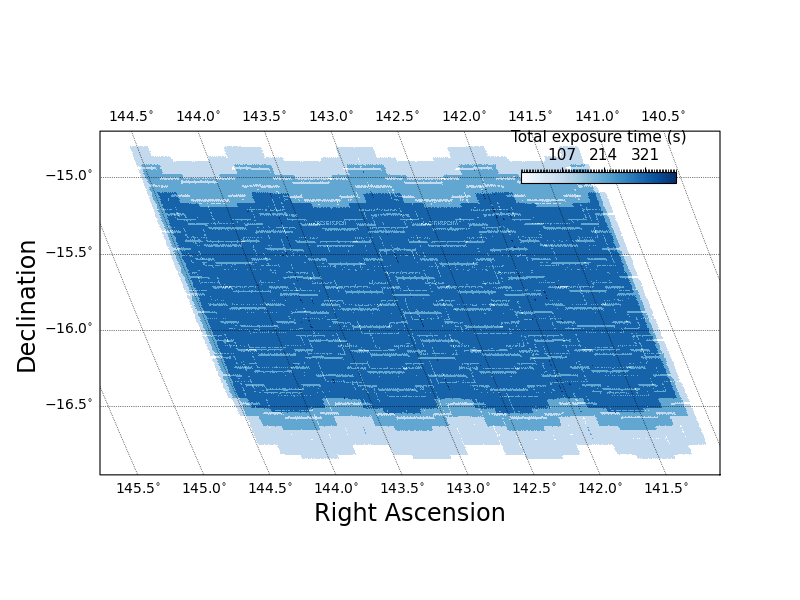

In [24]:
fig = plt.figure(4, figsize=(8, 6))
fig.clf()
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax)

# We define here a custom colorbar for illustration purposes
cmap = plt.cm.Blues  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0, 400, 100)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
# Note that the default is to zoom in to the range defined by the map
_ = sp.draw_hspmap(map_result, cmap=cmap, norm=norm)
# Set up the colorbar
cbar, _ = sp.draw_inset_colorbar(label='Total exposure time (s)', height='3%', bbox_to_anchor=(-0.06, -0.1, 1, 1), loc=1, ticks=[107, 214, 321])
cbar.ax.set_xticklabels(['107', '214', '321'])
plt.show()

Now, let's do all of the exposures using the F158 filter element.

In [25]:
map_here = client.map(partial(build_single_exp_map_cen, nside_sparse=nside_sparse, nside_cov=nside_cov), ra_sim, dec_sim, pa_sim, exp_time)

In [26]:
total = client.map(hsp.sum_union, [map_here])

In [27]:
map_f158 = total[0].result()

2025-10-06 15:43:04,131 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 12.88 GiB -- Worker memory limit: 16.00 GiB
2025-10-06 15:49:37,493 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 11.20 GiB -- Worker memory limit: 16.00 GiB
2025-10-06 15:49:43,849 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 11.20 GiB -- Worker memory limit: 16.00 GiB
2025-10-06 15:50:07,246 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memo

KilledWorker: Attempted to run task 'sum_union-96056e2d1c2717418b3e40e4193a86a0' on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:62507. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [ ]:
fig = plt.figure(5, figsize=(8, 6))
fig.clf()
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax)

# We define here a custom colorbar for illustration purposes
cmap = plt.cm.Blues  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0, 3000, 200)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
# Note that the default is to zoom in to the range defined by the map
_ = sp.draw_hspmap(map_f158, cmap=cmap, norm=norm)
# Set up the colorbar
cbar, _ = sp.draw_inset_colorbar(label='Total exposure time (s)', height='3%', bbox_to_anchor=(-0.06, -0.1, 1, 1), loc=1)
plt.show()

Note that the resulting `healsparse` maps can be saved to disk using the `write` method.

Disclaimer: Depending on the map resolution (controlled by the `nside` parameter) it can generate a very large file.

In [ ]:
# map_f158.write('./data/map_f158_all.hsp')  # Uncomment if you want to write the map to disk. With the default parameters in this notebook it should use 45 MB.

## Citations


If you use `astropy` for published research, please cite the
authors. Follow these links for more information about citing `astropy`: 

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)

## About this Notebook
Let the world know who the author of this great tutorial is! If possible and appropriate, include a contact email address for users who might need support (for example, `archive@stsci.edu`). You can also optionally include keywords, your funding source, or a last update date in this section.

**Author(s):** Javier Sánchez <br>
**Keyword(s):** Tutorial, visualization, footprint <br>
**Last Updated:** Oct 2025 <br>
**Next Review:** 
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 